# 🖼️ Convolutional Neural Networks for Multi-Class Classification on CIFAR-10

## Importing Necessary Libs and Classes

In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from Architecture import Architecture


## Define Seeds

In [2]:

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Data Preparation 🗃️

### Download CIFAR-10 Data

In [3]:
full_dataset = datasets.CIFAR10('data/', train=True, download=True, transform=None)

100%|██████████| 170M/170M [00:11<00:00, 14.6MB/s]


In [4]:
# 2. Split indices
n_total = len(full_dataset)
n_train = int(n_total * 0.8)
n_val   = n_total - n_train
train_idx, val_idx = random_split(list(range(n_total)), [n_train, n_val],generator=torch.Generator().manual_seed(SEED))

In [5]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),
                         (0.2470,0.2435,0.2616))
])
transform_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914,0.4822,0.4465),
                         (0.2470,0.2435,0.2616))
])

In [6]:
# 3. Dois datasets com transforms diferentes, aplicando os mesmos índices
train_ds = Subset(
    datasets.CIFAR10('data/', train=True, download=False, transform=transform_train),
    train_idx.indices
)
valid_ds = Subset(
    datasets.CIFAR10('data/', train=True, download=False, transform=transform_val),
    val_idx.indices
)

In [7]:
train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,  num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_ds, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

# 4. Test set final
test_ds    = datasets.CIFAR10('data/', train=False, download=True, transform=transform_val)
test_loader = DataLoader(test_ds, batch_size=128, shuffle=False, num_workers=2, pin_memory=True)

In [8]:
# 3. Modelo Base V1
class CNNV1(nn.Module):
    def __init__(self):
        super(CNNV1, self).__init__()
        self.conv1   = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1     = nn.BatchNorm2d(32)
        self.relu1   = nn.ReLU(inplace=True)
        self.conv2   = nn.Conv2d(32, 32, 3, padding=1)
        self.bn2     = nn.BatchNorm2d(32)
        self.relu2   = nn.ReLU(inplace=True)
        self.pool1   = nn.MaxPool2d(2)
        self.drop1   = nn.Dropout(0.2)

        self.conv3   = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3     = nn.BatchNorm2d(64)
        self.relu3   = nn.ReLU(inplace=True)
        self.conv4   = nn.Conv2d(64, 64, 3, padding=1)
        self.bn4     = nn.BatchNorm2d(64)
        self.relu4   = nn.ReLU(inplace=True)
        self.pool2   = nn.MaxPool2d(2)
        self.drop2   = nn.Dropout(0.3)

        self.conv5   = nn.Conv2d(64, 128, 3, padding=1)
        self.bn5     = nn.BatchNorm2d(128)
        self.relu5   = nn.ReLU(inplace=True)
        self.conv6   = nn.Conv2d(128, 128, 3, padding=1)
        self.bn6     = nn.BatchNorm2d(128)
        self.relu6   = nn.ReLU(inplace=True)
        self.pool3   = nn.MaxPool2d(2)
        self.drop3   = nn.Dropout(0.4)

        self.flatten = nn.Flatten()
        self.fc1     = nn.Linear(128*4*4, 128)
        self.bn7     = nn.BatchNorm1d(128)
        self.relu7   = nn.ReLU(inplace=True)
        self.drop4   = nn.Dropout(0.5)
        self.fc2     = nn.Linear(128, 10)

    def forward(self, x):
        x = self.relu1(self.bn1(self.conv1(x)))
        x = self.relu2(self.bn2(self.conv2(x)))
        x = self.drop1(self.pool1(x))
        x = self.relu3(self.bn3(self.conv3(x)))
        x = self.relu4(self.bn4(self.conv4(x)))
        x = self.drop2(self.pool2(x))
        x = self.relu5(self.bn5(self.conv5(x)))
        x = self.relu6(self.bn6(self.conv6(x)))
        x = self.drop3(self.pool3(x))
        x = self.flatten(x)
        x = self.relu7(self.bn7(self.fc1(x)))
        x = self.drop4(x)
        x = self.fc2(x)
        return x

In [10]:
# 4. Instanciar Architecture, loss, optimizer e scheduler
model     = CNNV1()
loss_fn   = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

net = Architecture(model, loss_fn, optimizer)
net.set_loaders(train_loader, valid_loader)

In [11]:
# 5. Função de acurácia
def compute_accuracy(loader):
    net.model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(net.device), y.to(net.device)
            logits = net.model(X)
            _, preds = torch.max(logits, 1)
            correct += (preds == y).sum().item()
            total   += y.size(0)
    return correct / total


In [ ]:
# 6. Loop de treino com verbose e early stopping
n_epochs = 20
best_val = float('inf')
patience = 10
trials   = 0

for epoch in range(1, n_epochs+1):
    net.train(1)
    scheduler.step()

    tr_loss = net.losses[-1]
    vl_loss = net.val_losses[-1]
    tr_acc  = compute_accuracy(train_loader)
    vl_acc  = compute_accuracy(valid_loader)

    print(f"Epoch {epoch:2d}/{n_epochs} — "
          f"train_loss: {tr_loss:.4f} — val_loss: {vl_loss:.4f} — "
          f"train_acc: {tr_acc:.4f} — val_acc: {vl_acc:.4f}")

    if vl_loss < best_val:
        best_val, trials = vl_loss, 0
        net.save_checkpoint('best_cnnv1.pth')
    else:
        trials += 1
        if trials >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

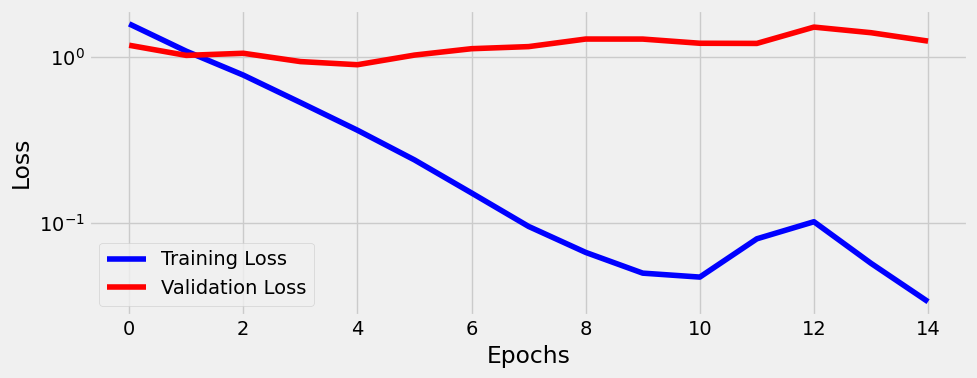

In [ ]:
# 7. Plot de perdas
net.plot_losses()
plt.show()

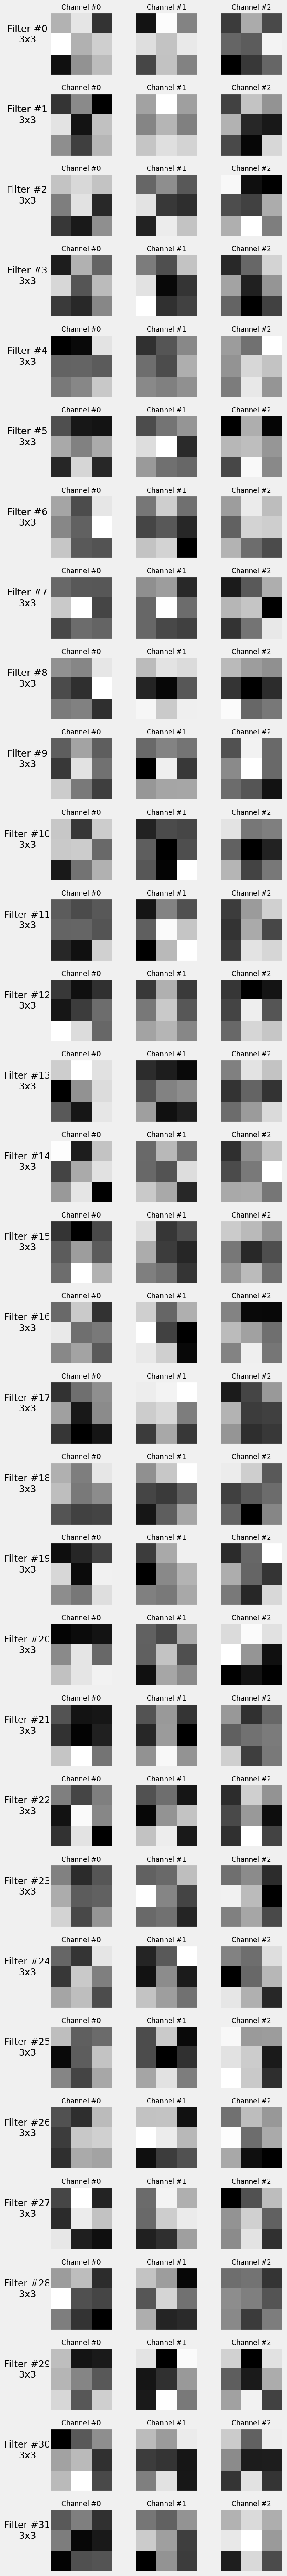

In [ ]:
# 8. Visualizar filtros da primeira Conv2d
fig = net.visualize_filters('conv1')
plt.show()

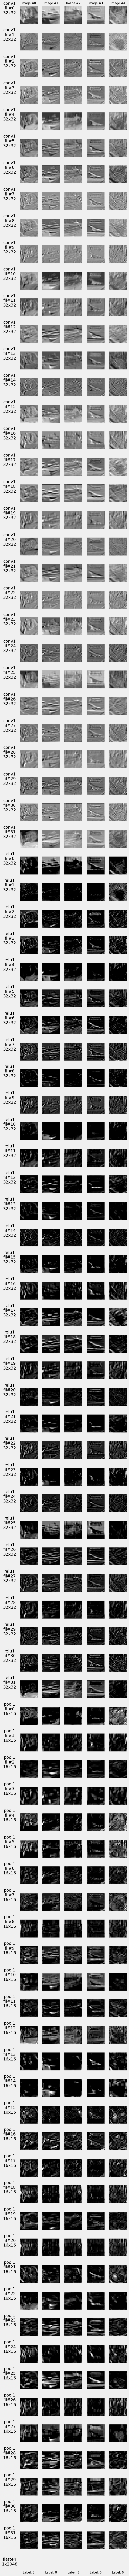

In [ ]:
# 9. Hooks e feature‐maps
layers_to_hook = ['conv1','relu1','pool1','flatten']
net.attach_hooks(layers_to_hook)

x_batch, y_batch = next(iter(val_loader))
with torch.no_grad():
    _ = net.model(x_batch.to(net.device))

fig2 = net.visualize_outputs(layers_to_hook, n_images=5, y=y_batch.numpy())
plt.show()
net.remove_hooks()

In [ ]:
net.model.eval() # --- 2. Colocar o modelo em modo eval

y_true, y_pred = [], []
with torch.no_grad():
    for X, y in test_loader:
        X = X.to(net.device)
        logits = net.model(X)
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(y.numpy())

 # --- 4. Calcular e mostrar acurácia
test_acc = np.mean(np.array(y_pred) == np.array(y_true))
print(f"Test Accuracy: {test_acc:.4f}")

In [ ]:
# --- 5. Gerar e plotar a confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=test_ds.classes)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix on Test Set")
plt.tight_layout()
plt.show()